In [2]:
import sys
import numpy as np
# import scikitlearn
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import glob

# ML Magic:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import (
    train_test_split,
    KFold
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_squared_error
)

from sklearn.preprocessing import (
    StandardScaler,
    Normalizer,
    MinMaxScaler
)

# Local includes:
sys.path.append("../../src/")
import therm_params as tp
from power_model import (
    leakagePower,
    peripheral_power,
    board_power
)


# Setting to make pandas show floats in non-scientific notation:
pd.options.display.float_format = '{:.3f}'.format

In [3]:
# blackscholes_files = glob.glob("../blackscholes_benchmarking/*.csv")
blackscholes_files = ["../blackscholes_benchmarking/userspace_ondemand_blackscholes.csv"]
bodytrack_files = glob.glob("../bodytrack_benchmarking/*.csv")
# random_data = ["../bodytrack_benchmarking/random_mc1_4_log_4_1_2018.csv"]
random_data = ["../bodytrack_benchmarking/xu4_random_loads_4_1_2018.csv"]
files = random_data

In [4]:
df_list = []

def leak_row_big(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_big_cluster, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)
    
def leak_row_little(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_little_cluster, \
            np.mean( [row.temp4, row.temp5, row.temp6, row.temp7, row.temp_gpu] ) + 273.15)

def leak_row_gpu(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_gpu, row.temp_gpu + 273.15 )

def leak_row_mem(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_mem, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)

for file in files:
    df = pd.read_csv(file, index_col=False, header=0, sep='\t')
    df_list.append(df)

def process_dataframe_list(df_list):
    data = pd.concat(df_list, ignore_index=True)
    # Drop all measurements where watts <= 0:
    data = data.loc[data.watts > 0]
    # fill in the potentially missing voltage values
    data["volts_big_cluster"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000])
    data["volts_little_cluster"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000])
    # Replace with correct value for gpu and mem voltage:
    data["volts_gpu"] = 1.0
    data["volts_mem"] = 1.2
    # Recompute the leakage power:
    data['leak_big'] = data.apply(leak_row_big, axis=1)
    data['leak_little'] = data.apply(leak_row_little, axis=1)
    data['leak_gpu'] = data.apply(leak_row_gpu, axis=1)
    data['leak_mem'] = data.apply(leak_row_mem, axis=1)
    data['w_leak2'] = data.apply(lambda row: np.sum( [row.leak_big, row.leak_little, row.leak_gpu, row.leak_mem] ), axis=1)

    data_filtered = data.copy()
    data_filtered["usage_little"] = data[["usage_c0", "usage_c1", "usage_c2", "usage_c3"]].apply(func = np.sum, axis=1)
    data_filtered["usage_big"] = data[["usage_c4", "usage_c5", "usage_c6", "usage_c7"]].apply(func = np.sum, axis=1)
    data_filtered["max_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.max, axis=1)
    data_filtered["avg_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.mean, axis=1)
    data_filtered["vvf_b"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000]**2 * x)
    data_filtered["vvf_l"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000]**2 * x)
    data_filtered["p_dyn"] = data.apply(lambda row: row.watts - row.w_leak2 - peripheral_power, axis=1)
    data_filtered["aVVFb"] = data_filtered.apply(lambda row: row.usage_big * row.vvf_b, axis=1)
    data_filtered["aVVFl"] = data_filtered.apply(lambda row: row.usage_little * row.vvf_l, axis=1)
    data_filtered["gpu_mem"] = 1
    data_filtered['p_total'] = data.watts
    data_filtered['p_leak'] = data.w_leak2
    # Sanity check:
    min_p_dyn = np.min(data_filtered.p_dyn.loc[data_filtered['p_dyn'] < 0])
    if not pd.isnull(min_p_dyn):
        data_filtered -= min_p_dyn
    return data_filtered

In [5]:
data_filtered = process_dataframe_list(df_list)
data_filtered.describe()

,time,watts,w_leak,w_dyn,w_periph,usage_c0,usage_c1,usage_c2,usage_c3,usage_c4,...,max_temp_big,avg_temp_big,vvf_b,vvf_l,p_dyn,aVVFb,aVVFl,gpu_mem,p_total,p_leak
count,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,...,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000,287005.000
mean,1515111551.526,3.114,0.241,0.622,2.257,0.107,0.087,0.088,0.108,0.190,...,46.281,44.727,1283877154.362,906265891.492,0.610,548706017.098,335516935.960,1.003,3.114,0.253
std,47258.757,0.717,0.043,0.679,0.000,0.279,0.268,0.274,0.300,0.306,...,5.153,4.177,909600812.740,618099637.718,0.677,957833709.186,691243594.201,0.000,0.717,0.045
min,1515042084.703,2.480,0.180,0.012,2.257,0.003,0.003,0.003,0.003,0.003,...,39.003,38.253,162000000.003,162000000.003,0.000,0.003,0.003,1.003,2.480,0.190
25%,1515056458.143,2.660,0.214,0.192,2.257,0.003,0.003,0.003,0.003,0.003,...,43.003,41.753,486000000.003,405000000.003,0.180,0.003,0.003,1.003,2.660,0.225
50%,1515137340.743,2.866,0.231,0.382,2.257,0.003,0.003,0.003,0.003,0.053,...,45.003,43.753,1045687500.003,800000000.003,0.370,107059523.815,0.003,1.003,2.866,0.243
75%,1515151713.943,3.278,0.253,0.777,2.257,0.050,0.003,0.003,0.003,0.179,...,48.003,46.503,1980250000.003,1361421875.003,0.764,664200000.006,324000000.003,1.003,3.278,0.265
max,1515166087.273,12.415,0.589,9.712,2.257,1.003,1.003,1.003,1.003,1.003,...,81.003,73.503,3380000000.003,2187500000.003,9.687,12875458874.457,7394400000.001,1.003,12.415,0.624


In [6]:
X = data_filtered.loc[:, ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem", "p_leak"]]
y = data_filtered.p_total
# Or:
# y = data_filtered.p_dyn

# Fit and apply a scaler to the data:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# Estimate C values for the model (built-in cross validation):
DPM = RidgeCV(alphas = np.linspace(0.001, 100, 100), cv=5, normalize=False, fit_intercept=True)
# # Create training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)#, shuffle=True) 
DPM = DPM.fit(X_train,y_train)
P = DPM.predict(X_test)

In [7]:
R = DPM.score(X_test, y_test)
R

0.88890398338185972

In [8]:
mean_squared_error( list(y_test.values), list(P) )

0.056864148008960523

In [9]:
pd.DataFrame([list(P), list(y_test.values)] )

,0,1,2,3,4,5,6,7,8,9,...,86092,86093,86094,86095,86096,86097,86098,86099,86100,86101
0,3.452,2.779,2.546,3.021,3.028,2.700,2.505,2.800,2.844,2.757,...,2.664,2.768,3.171,2.822,3.545,3.322,4.790,3.003,3.216,2.813
1,3.469,2.694,2.618,2.843,3.198,2.698,2.537,2.782,2.660,2.621,...,2.644,2.686,3.030,2.675,3.610,3.247,4.503,2.808,3.327,2.671


In [10]:
# Load some other data and test/plot it:
f_test = "../blackscholes_benchmarking/userspace_ondemand_blackscholes.csv"
# Or:
# f_test = "../bodytrack_benchmarking/userspace_ondemand_bodytrack.csv"

to_plot = pd.read_csv(f_test, index_col=False, header=0, sep='\t')
other_XY = process_dataframe_list([to_plot])

In [11]:
X_plot = other_XY.loc[:, ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem", "p_leak"]]
X_plot = scaler.transform(X_plot)
# y_plot = other_XY.p_dyn
y_plot = other_XY.p_total

In [12]:
P_plot = DPM.predict(X_plot)
DPM.score(X_plot, y_plot)

0.95330638757792385

In [13]:
mean_squared_error( list(y_plot.values), list(P_plot) )

0.26045932582228898

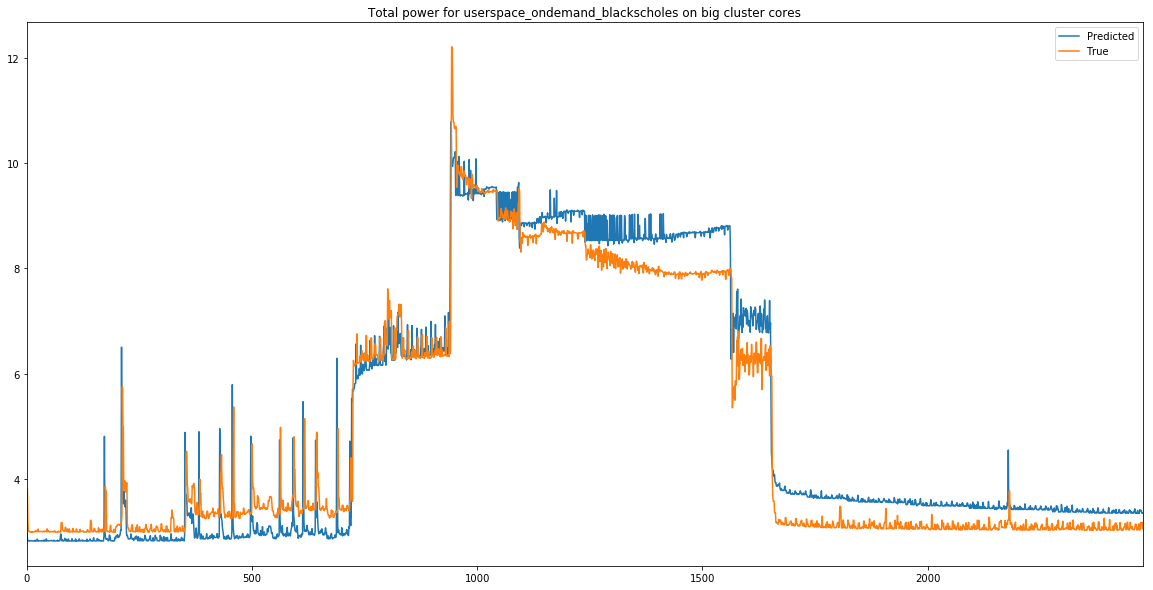

In [14]:
plt.rcParams["figure.figsize"] = [20,10]
plt.plot(range(len(P_plot)), P_plot, label="Predicted")
y_plot.plot(label="True")
plt.legend()
plt.title("Total power for {} on big cluster cores".format(f_test[f_test.rfind('/')+1:f_test.rfind('.')]))
plt.show()

In [15]:
X_hack = np.identity(X.shape[1])
model_coeffs = DPM.predict(X_hack)
print("Model coefficients:")
print(model_coeffs)

#using from above:
# def leak_row_big(row):
# def leak_row_little(row):
# Defining now:
def dyn_row_big(row):
    global model_coeffs
    return row.aVVFb * model_coeffs[0] + row.vvf_b * model_coeffs[1]

def dyn_row_little(row):
    global model_coeffs
    return row.aVVFl * model_coeffs[2] + row.vvf_l * model_coeffs[3]

Model coefficients:
[ 6.95454933  2.78515399  3.00094391  2.31650832  2.33122824  5.08199098]


In [16]:
foo = pd.DataFrame(data=X_plot, columns = ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem", "p_leak"])

In [17]:
dyn_power_est = other_XY.loc[:,['time', 'temp4', 'temp5', 'temp6', 'temp7']].copy()
# Estimate the dynamic power for the big cluster:
dyn_power_est['big_dyn'] = foo.apply(dyn_row_big, axis=1)
    
# Total power for big cluster is dynamic plus leakage:
dyn_power_est['big_tot'] = other_XY['leak_big'] + dyn_power_est['big_dyn']

In [18]:
# Estimate the dynamic power for the LITTLE cluster:
dyn_power_est['little_dyn'] = foo.apply(dyn_row_little, axis=1)

# Total power for LITTLE cluster is dynamic plus leakage:
dyn_power_est['little_tot'] = other_XY['leak_little'] + dyn_power_est['little_dyn']

In [19]:
dyn_power_est['little_dyn'].describe()

count   2477.000
mean       0.018
std        0.019
min       -0.000
25%        0.009
50%        0.013
75%        0.019
max        0.144
Name: little_dyn, dtype: float64

In [20]:
dyn_power_est['big_dyn'].describe()

count   2477.000
mean       2.294
std        2.887
min       -0.000
25%        0.005
50%        0.106
75%        5.745
max       10.088
Name: big_dyn, dtype: float64

In [21]:
# Generate a set of unique colors so that two separate axes won't share any colors
def genColor(num_curves=10):
    jet = cm = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=0, vmax=num_curves-1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    idx = 0
    while idx < num_curves:
        colorVal = scalarMap.to_rgba(idx)
#     colorText = (
#         'color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2])
#         )
        idx += 1
        yield colorVal

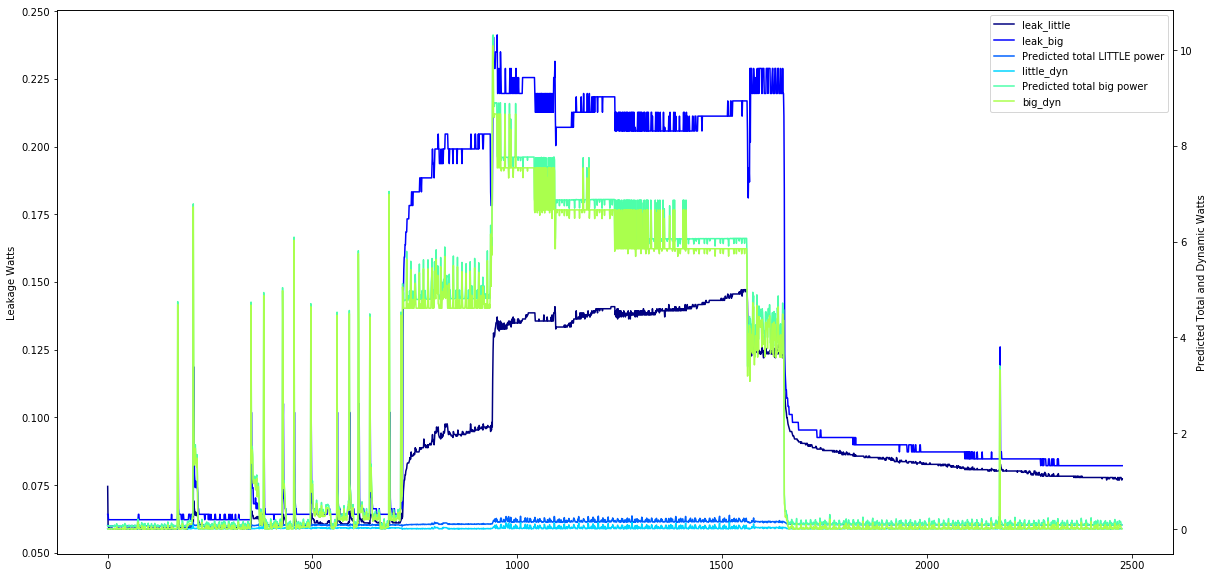

In [22]:
# Plot data for both big and little clusters
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.rcParams["figure.figsize"] = [20,10]

color_gen = genColor(10)

# little cluster leakage
lns1 = ax1.plot(range(len(other_XY.leak_little)), other_XY.leak_little, color=next(color_gen), label="leak_little")
# big cluster leakage
lns2 = ax1.plot(range(len(other_XY.leak_big)), other_XY.leak_big, color=next(color_gen), label="leak_big")
ax1.set_ylabel("Leakage Watts")
ax2 = ax1.twinx()
# Little cluster
lns3 = ax2.plot(range(len(dyn_power_est.little_tot)), dyn_power_est.little_tot, color=next(color_gen), label="Predicted total LITTLE power")
lns4 = ax2.plot(range(len(dyn_power_est.little_dyn)), dyn_power_est.little_dyn, color=next(color_gen), label="little_dyn")
# big cluster
lns5 = ax2.plot(range(len(dyn_power_est.big_tot)), dyn_power_est.big_tot, color=next(color_gen), label="Predicted total big power")
lns6 = ax2.plot(range(len(dyn_power_est.big_dyn)), dyn_power_est.big_dyn, color=next(color_gen), label="big_dyn")
ax2.set_ylabel("Predicted Total and Dynamic Watts")

lns = lns1 + lns2 + lns3 + lns4 + lns5 + lns6
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.show()

In [23]:
other_XY['scaled_usage_0'] = other_XY.apply(lambda row: 0.25 if \
                    row.usage_little == 0 else row.usage_c0/row.usage_little, axis=1)
other_XY['scaled_usage_1'] = other_XY.apply(lambda row: 0.25 if \
                    row.usage_little == 0 else row.usage_c1/row.usage_little, axis=1)
other_XY['scaled_usage_2'] = other_XY.apply(lambda row: 0.25 if \
                    row.usage_little == 0 else row.usage_c2/row.usage_little, axis=1)
other_XY['scaled_usage_3'] = other_XY.apply(lambda row: 0.25 if \
                    row.usage_little == 0 else row.usage_c3/row.usage_little, axis=1)

In [24]:
other_XY['scaled_usage_4'] = other_XY.apply(lambda row: 0.25 if \
                        row.usage_big < 0.02 else row.usage_c4/row.usage_big, axis=1)
other_XY['scaled_usage_5'] = other_XY.apply(lambda row: 0.25 if \
                        row.usage_big < 0.02 else row.usage_c5/row.usage_big, axis=1)
other_XY['scaled_usage_6'] = other_XY.apply(lambda row: 0.25 if \
                        row.usage_big < 0.02 else row.usage_c6/row.usage_big, axis=1)
other_XY['scaled_usage_7'] = other_XY.apply(lambda row: 0.25 if \
                        row.usage_big < 0.02 else row.usage_c7/row.usage_big, axis=1)

In [25]:
dyn_power_est['0_tot'] = other_XY.scaled_usage_0 * dyn_power_est.little_dyn + 0.25 * other_XY.leak_little
dyn_power_est['1_tot'] = other_XY.scaled_usage_1 * dyn_power_est.little_dyn + 0.25 * other_XY.leak_little
dyn_power_est['2_tot'] = other_XY.scaled_usage_2 * dyn_power_est.little_dyn + 0.25 * other_XY.leak_little
dyn_power_est['3_tot'] = other_XY.scaled_usage_3 * dyn_power_est.little_dyn + 0.25 * other_XY.leak_little
dyn_power_est['4_tot'] = other_XY.scaled_usage_4 * dyn_power_est.big_dyn + 0.25 * other_XY.leak_big
dyn_power_est['5_tot'] = other_XY.scaled_usage_5 * dyn_power_est.big_dyn + 0.25 * other_XY.leak_big
dyn_power_est['6_tot'] = other_XY.scaled_usage_6 * dyn_power_est.big_dyn + 0.25 * other_XY.leak_big
dyn_power_est['7_tot'] = other_XY.scaled_usage_7 * dyn_power_est.big_dyn + 0.25 * other_XY.leak_big

In [26]:
dyn_power_est.to_csv("matlab_temp_sys_identification_verification_blackscholes.csv", sep=',', index=False)

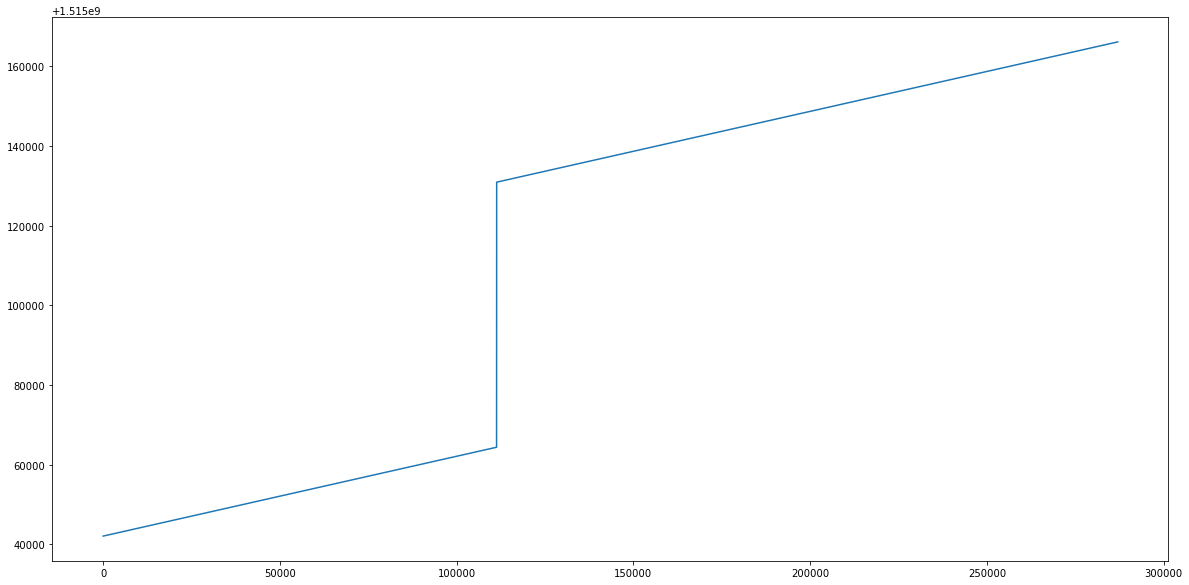

In [29]:
# Make sure the training data is continuous:
plt.plot(data_filtered.index, data_filtered.time)
plt.show()
# (It's not, so just select from indices [120000:])
data_filtered_slice = data_filtered.loc[120000:300000, :].copy()

In [23]:
# Now to use the estimates for cluster dynamic + leakage = total power 
# to make predictions on thermals per big core:
# T_next = T_now * A + P_now_est * B
# T_now is the vector of temperatures measured on the system: [T4, T5, T6, T7]
# Note: in other work the GPU temperature could be included and predicted as well.
# P_now_est is the vector of estimated powers used by each big core: [P4, P5, P6, P7]
# Note: it may make more sense to include the power estimate for the little core/clusters as well?
# T_next is the corresponding vector to T_now of temperatures, except that the values are predicted.

In [31]:
# First need to output data with which to do system identification
# From the entire random input (30% of which was used for training),
# generate the estimated power for the big and little clusters:
data_transformed = scaler.transform(data_filtered_slice.loc[:,["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem", "p_leak"]])
foo2 = pd.DataFrame(data=data_transformed, columns = ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem", "p_leak"])
sys_identification_data = data_filtered_slice.loc[:,['time', 'temp4', 'temp5', 'temp6', 'temp7']].copy()
sys_identification_data['big_dyn'] = foo2.apply(dyn_row_big, axis=1)
sys_identification_data['little_dyn'] = foo2.apply(dyn_row_little, axis=1)

In [32]:
data_filtered_slice['scaled_usage_0'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_little == 0 else row.usage_c0/row.usage_little, axis=1)
data_filtered_slice['scaled_usage_1'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_little == 0 else row.usage_c1/row.usage_little, axis=1)
data_filtered_slice['scaled_usage_2'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_little == 0 else row.usage_c2/row.usage_little, axis=1)
data_filtered_slice['scaled_usage_3'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_little == 0 else row.usage_c3/row.usage_little, axis=1)

In [33]:
data_filtered_slice['scaled_usage_4'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_big < 0.02 else row.usage_c4/row.usage_big, axis=1)
data_filtered_slice['scaled_usage_5'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_big < 0.02 else row.usage_c5/row.usage_big, axis=1)
data_filtered_slice['scaled_usage_6'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_big < 0.02 else row.usage_c6/row.usage_big, axis=1)
data_filtered_slice['scaled_usage_7'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_big < 0.02 else row.usage_c7/row.usage_big, axis=1)

In [34]:
sys_identification_data['0_tot'] = data_filtered_slice.scaled_usage_0 * sys_identification_data.little_dyn + 0.25 * data_filtered_slice.leak_little
sys_identification_data['1_tot'] = data_filtered_slice.scaled_usage_1 * sys_identification_data.little_dyn + 0.25 * data_filtered_slice.leak_little
sys_identification_data['2_tot'] = data_filtered_slice.scaled_usage_2 * sys_identification_data.little_dyn + 0.25 * data_filtered_slice.leak_little
sys_identification_data['3_tot'] = data_filtered_slice.scaled_usage_3 * sys_identification_data.little_dyn + 0.25 * data_filtered_slice.leak_little
sys_identification_data['4_tot'] = data_filtered_slice.scaled_usage_4 * sys_identification_data.big_dyn + 0.25 * data_filtered_slice.leak_big
sys_identification_data['5_tot'] = data_filtered_slice.scaled_usage_5 * sys_identification_data.big_dyn + 0.25 * data_filtered_slice.leak_big
sys_identification_data['6_tot'] = data_filtered_slice.scaled_usage_6 * sys_identification_data.big_dyn + 0.25 * data_filtered_slice.leak_big
sys_identification_data['7_tot'] = data_filtered_slice.scaled_usage_7 * sys_identification_data.big_dyn + 0.25 * data_filtered_slice.leak_big

In [38]:
sys_identification_data2 = sys_identification_data.copy(deep=True)
sys_identification_data2.dropna(axis=0, how='any', inplace=True)
sys_identification_data2.describe()

,time,temp4,temp5,temp6,temp7,big_dyn,little_dyn,0_tot,1_tot,2_tot,3_tot,4_tot,5_tot,6_tot,7_tot,temp4_next,temp5_next,temp6_next,temp7_next
count,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000,47006.000
mean,1515137340.624,43.124,45.443,46.084,43.792,1.271,0.960,0.677,0.614,0.557,0.721,0.690,0.216,0.320,0.175,43.124,45.443,46.084,43.792
std,2718.338,3.423,4.401,4.942,3.432,1.065,0.772,0.757,0.739,0.724,0.790,0.822,0.315,0.543,0.247,3.423,4.401,4.942,3.432
min,1515132632.543,38.003,40.003,40.003,39.003,0.000,0.000,0.012,0.012,0.012,0.012,0.014,0.013,0.013,0.013,38.003,40.003,40.003,39.003
25%,1515134986.493,41.003,43.003,43.003,42.003,0.437,0.286,0.021,0.020,0.019,0.046,0.130,0.035,0.051,0.029,41.003,43.003,43.003,42.003
50%,1515137340.643,42.003,44.003,45.003,43.003,1.042,0.730,0.416,0.291,0.199,0.417,0.375,0.094,0.129,0.076,42.003,44.003,45.003,43.003
75%,1515139694.753,44.003,46.003,47.003,45.003,1.923,1.605,1.151,1.004,0.936,1.153,0.912,0.275,0.381,0.209,44.003,46.003,47.003,45.003
max,1515142048.733,65.003,80.003,81.003,70.003,9.740,4.043,4.057,4.057,4.057,4.057,9.224,6.451,5.953,6.456,65.003,80.003,81.003,70.003


In [39]:
sys_identification_data2.to_csv("matlab_temp_sys_identification.csv", sep=',', index=False)